# EDA

In [18]:
import os, sys
from datetime import datetime, timedelta
from collections import Counter

import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

data_path = "../kgdata/edges_v3.tsv"
tmp_dir = "../tmp/"
output_dir = "../output/"

if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

graph_cache = tmp_dir + "wikidata.sqlite3"

df = pd.read_csv(data_path, sep='\t')

In [2]:
print(df["label"].unique())

['type' 'EventId' 'DescriptionText' 'EventType' 'StartTime' 'EndTime'
 'StartDistanceFromPort_km' 'StartDistanceFromShore_km'
 'EndDistanceFromPort_km' 'EndDistanceFromShore_km' 'Location'
 'EventGeometry' 'HasParticipant' 'ValidatedBy' 'ExplainedBy'
 'HasProvenance' 'BehaviorType' 'UncertaintyNote' 'AvgSpeed_knots'
 'PatternGeometry' 'UnexplainedByWeatherOrPort' 'ObservationId' 'MMSI'
 'Lat' 'Lon' 'Speed' 'Course' 'Timestamp' 'DistanceFromPortKM'
 'DistanceFromShoreKM' 'Source' 'SSVID' 'VesselName' 'CallSign' 'Flag'
 'VesselTypeId' 'GroupType' 'HasMember' 'AsWKT' 'CentroidLat'
 'CentroidLon' 'CRS' 'PortName' 'BerthGeometry' 'TypeCode' 'TypeName'
 'subClassOf' 'FishingEffortScore' 'GearType' 'ZoneCode' 'ZoneName'
 'ZoneType' 'ZoneGeometry' 'SourceID' 'SourceName' 'SourceType'
 'SourceURL' 'MemberVessel' 'MembershipRole' 'MemberOf' 'PatternTypeID'
 'PatternTypeName' 'domain' 'range' ' type']


In [3]:
tmp = df[df["label"] == "MMSI"]
vessel2mmsi = dict(tmp[tmp.node1.apply(lambda x: x.startswith("VesselIdentity"))][["node1", "node2"]].values)

def mmsi2ais(mmsi: str):
    tmp = df[(df["label"] == "MMSI") & (df["node2"] == mmsi)]
    return tmp[tmp["edge_id"].apply(lambda x: x.startswith("AIS"))].node1.unique()

def ais2timestamp(ais: str):
    tmp = df[df["node1"] == ais]
    return tmp[tmp["label"] == "Timestamp"].node2.values[0]

def ais2latlon(ais: str):
    tmp = df[df["node1"] == ais]
    lat = float(tmp[tmp["label"] == "Lat"].node2.values[0])
    lon = float(tmp[tmp["label"] == "Lon"].node2.values[0])
    return lat, lon

ais = mmsi2ais(vessel2mmsi["VesselIdentity_0"])
timestamps = list(map(lambda x: ais2timestamp(x), ais))
#def mmsi

In [4]:
# ISO 8601
timestamp = timestamps[0]
datetime.strptime(timestamp, "^%Y-%m-%dT%H:%M:%S%z")

datetime.datetime(2014, 8, 21, 7, 19, 19, tzinfo=datetime.timezone.utc)

In [5]:
timestamps = list(map(lambda x: datetime.strptime(x, "^%Y-%m-%dT%H:%M:%S%z"), timestamps))
timestamps = sorted(timestamps)

In [6]:
print(timestamps[:10])
print(timestamps[1] - timestamps[0])

[datetime.datetime(2014, 8, 21, 7, 19, 19, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 7, 31, 53, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 8, 34, 5, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 9, 25, 36, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 10, 25, 58, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 10, 51, 21, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 11, 16, 55, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 11, 45, 3, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 12, 22, 11, tzinfo=datetime.timezone.utc), datetime.datetime(2014, 8, 21, 12, 35, 46, tzinfo=datetime.timezone.utc)]
0:12:34


In [7]:
def vessel_ais_diff_plot(vessel: str):
    ais = mmsi2ais(vessel2mmsi[vessel])
    timestamps = list(map(lambda x: ais2timestamp(x), ais))
    timestamps = list(map(lambda x: datetime.strptime(x, "^%Y-%m-%dT%H:%M:%S%z"), timestamps))
    timestamps = sorted(timestamps)

    dt = list(map(lambda x: x.total_seconds(), np.diff(timestamps)))
    plt.plot(dt, marker='o')
    plt.show()

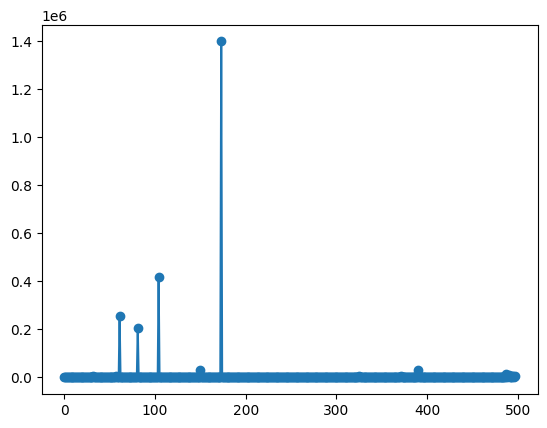

In [8]:
vessel_ais_diff_plot("VesselIdentity_0")

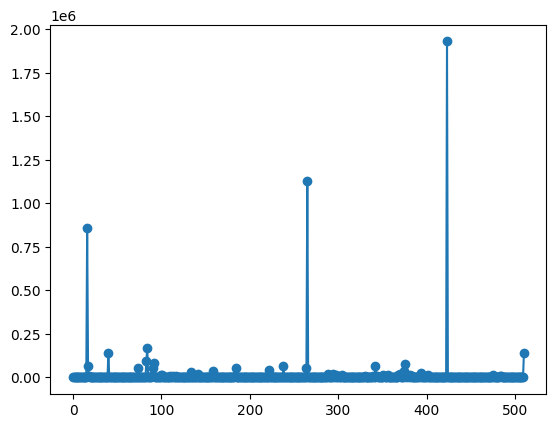

In [9]:
vessel_ais_diff_plot("VesselIdentity_1")

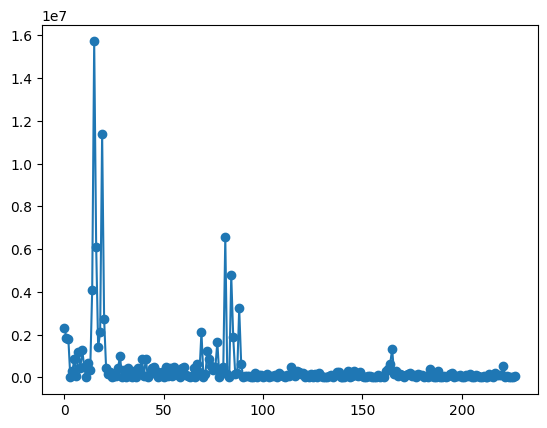

In [10]:
vessel_ais_diff_plot("VesselIdentity_2")

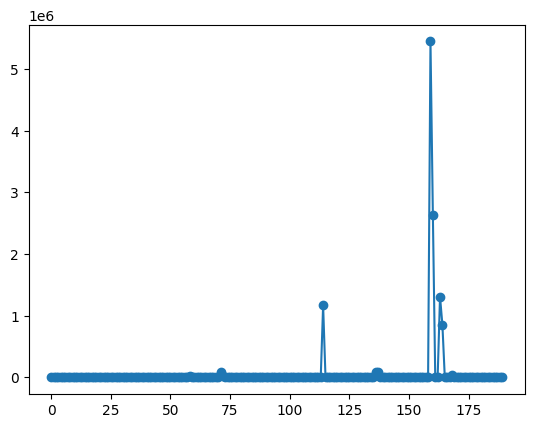

In [11]:
vessel_ais_diff_plot("VesselIdentity_3")

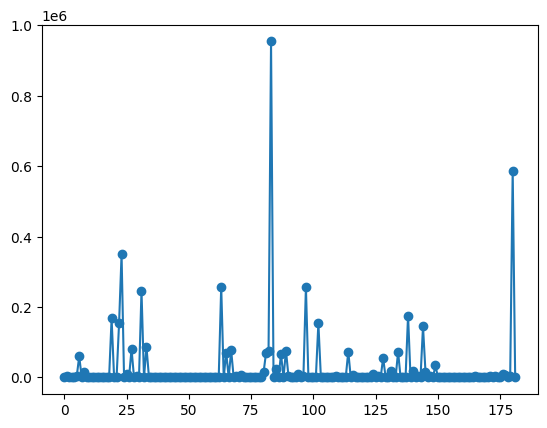

In [12]:
vessel_ais_diff_plot("VesselIdentity_4")

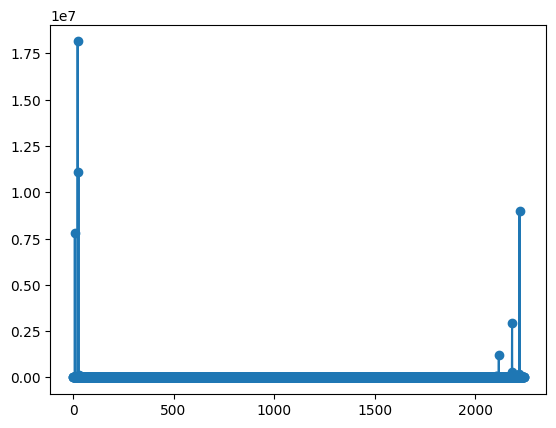

In [13]:
vessel_ais_diff_plot("VesselIdentity_5")

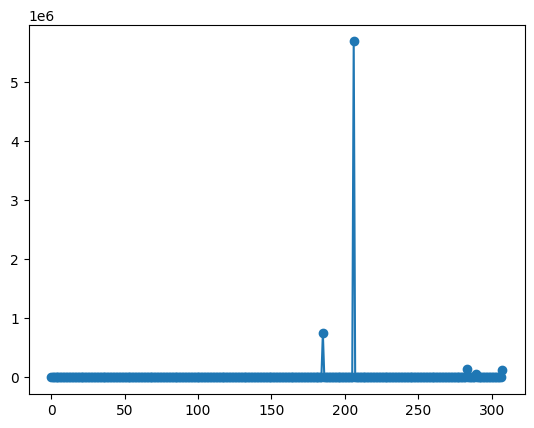

In [14]:
vessel_ais_diff_plot("VesselIdentity_6")

In [15]:
print(1e6 / (3600 * 24))

11.574074074074074


In [51]:
def linear_interpolation(vessel: str):	# line interpolation
    def middle_latlon(start_time, end_time, middle_time,
                      start_location, end_location):
        ttime = (end_time - start_time).total_seconds()
        ptime = (middle_time - start_time).total_seconds()
        
        ratio = ptime / ttime
        
        return (start_location[0] + ratio * (end_location[0] - start_location[0]),
                start_location[1] + ratio * (end_location[1] - start_location[1]))
    
    def oclock_fill(x, y):	# (x, y]
        filled = []
        
        time = x[0].replace(minute=0, second=0) + timedelta(hours=1)
        while time < y[0]:
            filled.append((False,) + middle_latlon(x[0], y[0], time, x[1], y[1]))
            time += timedelta(hours=1)
        
        filled.append((True,) + y[1])
        
        return filled    
    
    ais = mmsi2ais(vessel2mmsi[vessel])
    datetime_latlon = [(datetime.strptime(ais2timestamp(x), "^%Y-%m-%dT%H:%M:%S%z"), ais2latlon(x)) \
                           for x in ais]
    datetime_latlon = sorted(datetime_latlon, key=lambda x: x[0])
    
    traverse_route = [[(True,) + datetime_latlon[0][1]]]
    for i in range(1, len(datetime_latlon)):
        if (datetime_latlon[i][0] - datetime_latlon[i - 1][0]).days == 0:
            traverse_route[-1].extend(oclock_fill(datetime_latlon[i - 1], datetime_latlon[i]))
        else:
            traverse_route.append([(True,) + datetime_latlon[i][1]])
    
    return traverse_route

def interpolated_route_plot(interpolated_route: List):
    route_size = len(interpolated_route)
    fig, axes = plt.subplots(route_size, 1, figsize=(8, 12))

    lat_min = 90; lat_max = -90; lon_min = 180; lon_max = -180
    for routes in interpolated_route:
        lats = np.array([route[1] for route in routes])
        lons = np.array([route[2] for route in routes])
        lat_min = min(lat_min, lats.min())
        lat_max = max(lat_max, lats.max())
        lon_min = min(lon_min, lons.min())
        lon_max = max(lon_max, lons.max())

    lat_min -= 0.01; lat_max += 0.01
    lon_min -= 0.01; lon_max += 0.01
    
    for i, ax in enumerate(axes):
        flag = np.array([route[0] for route in interpolated_route[i]])
        lats = np.array([route[1] for route in interpolated_route[i]])
        lons = np.array([route[2] for route in interpolated_route[i]])
        
        world_map = Basemap(projection="mill",
                            lon_0=0,
                            llcrnrlat=lat_min,
                            urcrnrlat=lat_max,
                            llcrnrlon=lon_min,
                            urcrnrlon=lon_max,
                            resolution='i',
                            ax=ax)
        world_map.drawcoastlines()
        world_map.drawmapboundary(fill_color="lightblue")
        world_map.fillcontinents(color="lightgray", lake_color="lightblue")
        x, y = world_map(lons, lats)
        
        ax.scatter(x[flag], y[flag], marker='x', c="black")
        ax.scatter(x[~flag], y[~flag], marker='o', c="red")
    
    plt.tight_layout()
    plt.show()

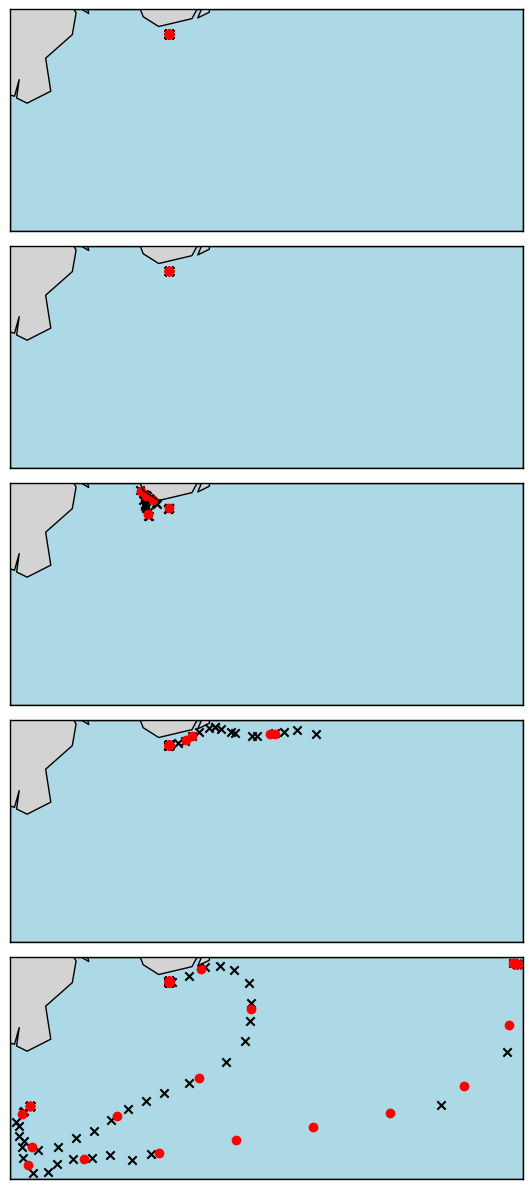

In [52]:
interpolated_route = linear_interpolation("VesselIdentity_0")
interpolated_route_plot(interpolated_route)

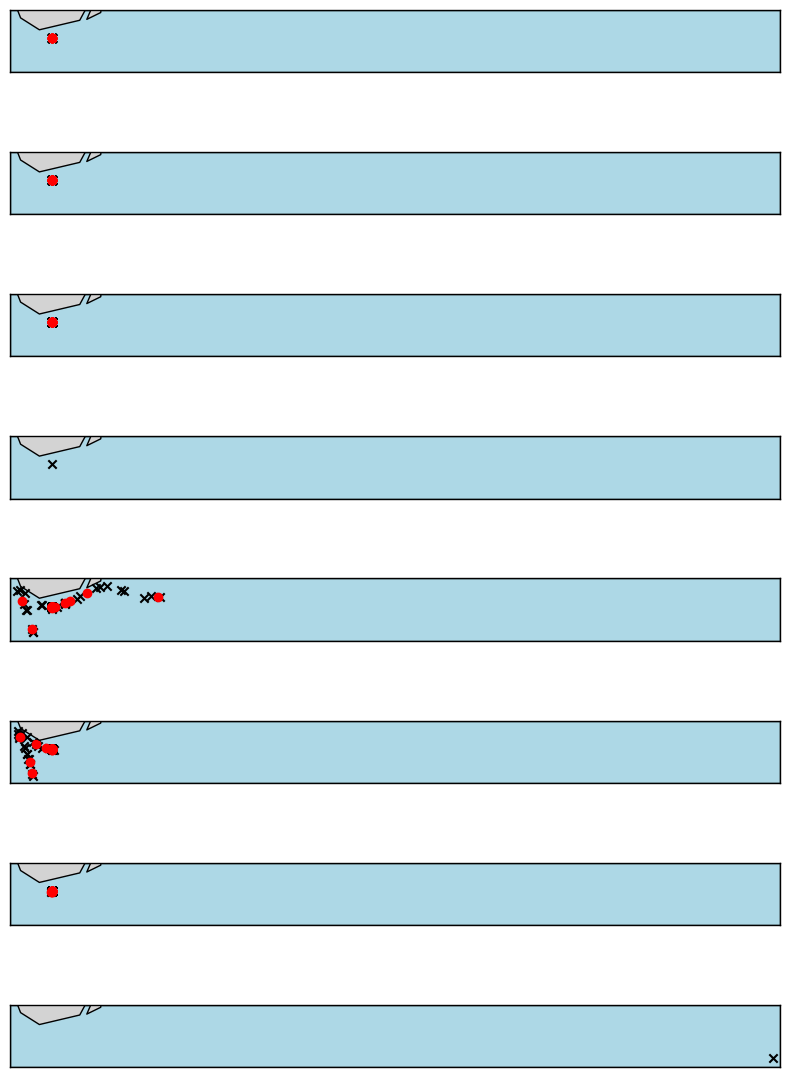

In [53]:
interpolated_route = linear_interpolation("VesselIdentity_1")
interpolated_route_plot(interpolated_route)

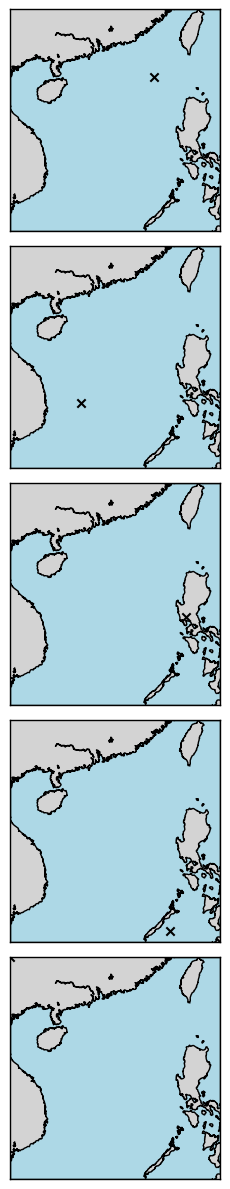

In [56]:
interpolated_route = linear_interpolation("VesselIdentity_2")
interpolated_route_plot(interpolated_route[0:5])

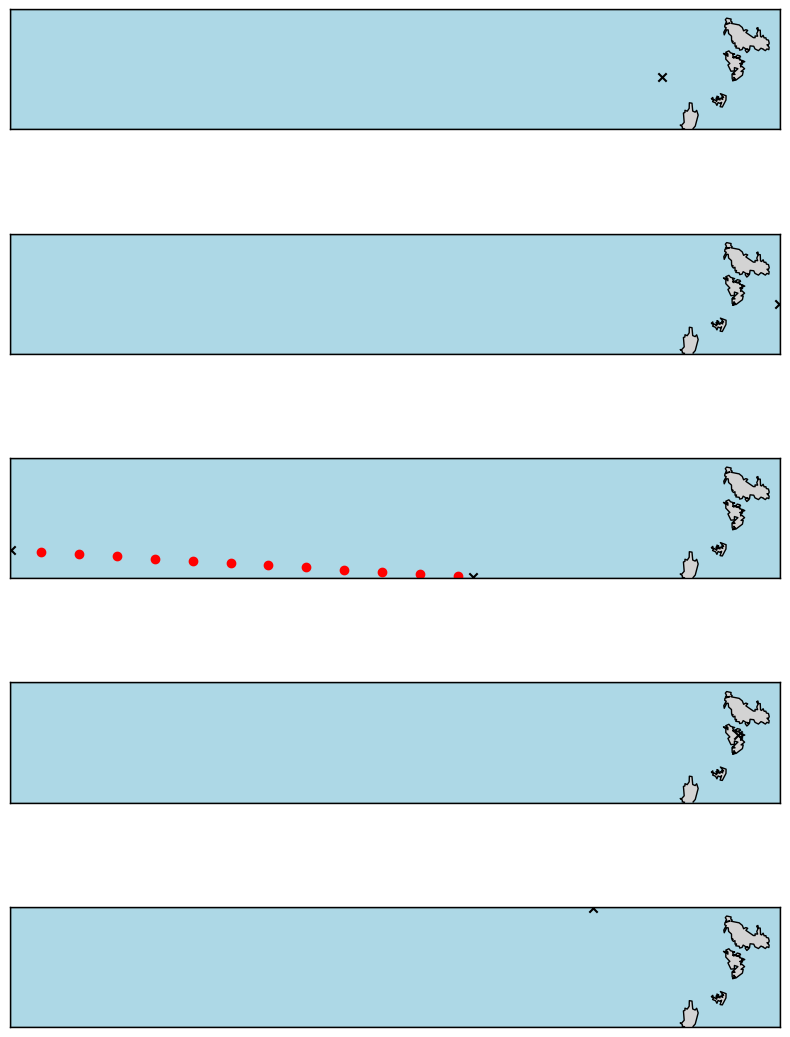

In [59]:
interpolated_route_plot(interpolated_route[20:25])

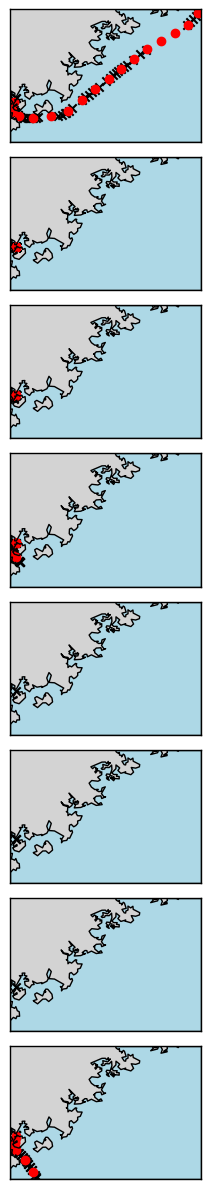

In [60]:
interpolated_route = linear_interpolation("VesselIdentity_3")
interpolated_route_plot(interpolated_route)